In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
RANDOM_SEED = 42

Using TensorFlow backend.


# Load Dataset

In [2]:
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('data/WISDM_ar_v1.1_raw.txt', header = None, names = columns)
df = df.dropna()

In [3]:
print('Total rows : ', len(df))
df.head()

Total rows :  1098203


,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


## Plot Activity Types

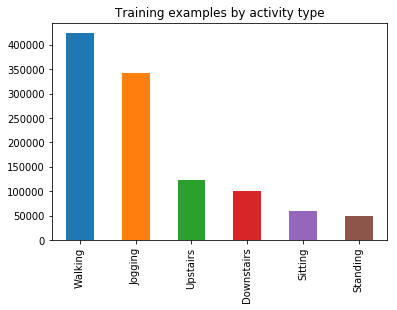

In [4]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

# Normalize Training Data

In [5]:
# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'

df['x-axis'] = df['x-axis'] / df['x-axis'].max()
df['y-axis'] = df['y-axis'] / df['y-axis'].max()
df['z-axis'] = df['z-axis'] / df['z-axis'].max()
# Round numbers
df = df.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

## Data Preprocessing

In [6]:
N_TIME_STEPS = 200
N_FEATURES = 3
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

C:\Users\admin\Anaconda3\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [7]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)


In [8]:
print(reshaped_segments.shape)
print(labels[0])

(54901, 200, 3)
[0. 1. 0. 0. 0. 0.]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.5, random_state=RANDOM_SEED)

In [10]:
print('X_train : ', len(X_train))
print('X_test : ', len(X_test))

X_train :  27450
X_test :  27451


In [11]:
verbose = 1
epochs = 10
batch_size = 400

n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = y_train.shape[1]

print('n_timesteps : ', n_timesteps)
print('n_features : ', n_features)
print('n_outputs : ', n_outputs)

n_timesteps :  200
n_features :  3
n_outputs :  6


In [12]:
checkpoint = ModelCheckpoint("wisdm_weights.h5", monitor='val_acc', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [13]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding = 'same'))
model.add(Dropout(0.4))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))


In [14]:
# Load Weights
final_model = Model(inputs = model.input, outputs = model.output)
#final_model.load_weights('./har_weights.h5')
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit network
history = final_model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=epochs, batch_size=batch_size, callbacks = [checkpoint], verbose=verbose)


# evaluate model
(loss, accuracy) = final_model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy * 100))

Train on 27450 samples, validate on 27451 samples
Epoch 1/10
27450/27450 [==============================] - 49s 2ms/step - loss: 0.7255 - acc: 0.7325 - val_loss: 0.5023 - val_acc: 0.8227

Epoch 00001: val_acc improved from -inf to 0.82274, saving model to wisdm_weights.h5
Epoch 2/10
27450/27450 [==============================] - 48s 2ms/step - loss: 0.3985 - acc: 0.8485 - val_loss: 0.3787 - val_acc: 0.8521

Epoch 00002: val_acc improved from 0.82274 to 0.85210, saving model to wisdm_weights.h5
Epoch 3/10
27450/27450 [==============================] - 48s 2ms/step - loss: 0.3067 - acc: 0.8877 - val_loss: 0.3393 - val_acc: 0.8739

Epoch 00003: val_acc improved from 0.85210 to 0.87388, saving model to wisdm_weights.h5
Epoch 4/10
27450/27450 [==============================] - 48s 2ms/step - loss: 0.2531 - acc: 0.9101 - val_loss: 0.2676 - val_acc: 0.8951

Epoch 00004: val_acc improved from 0.87388 to 0.89509, saving model to wisdm_weights.h5
Epoch 5/10
27450/27450 [=========================

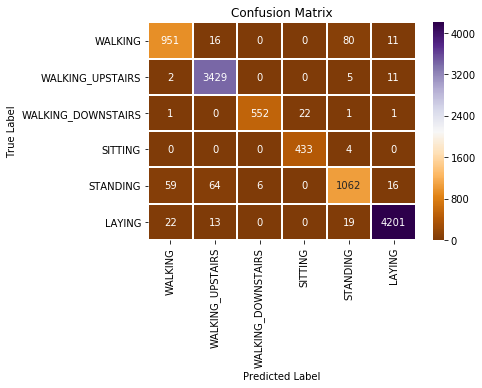

In [15]:

# Print confusion matrix for training data
y_pred_train = final_model.predict(X_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
#print(classification_report(trainy, max_y_pred_train))

# confusion matrix
LABELS = ['WALKING',
          'WALKING_UPSTAIRS',
          'WALKING_DOWNSTAIRS',
          'SITTING',
          'STANDING',
          'LAYING']
y_pred_test = final_model.predict(X_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

matrix = metrics.confusion_matrix(max_y_test, max_y_pred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(matrix,
            cmap='PuOr',
            linecolor='white',
            linewidths=1,
            xticklabels=LABELS,
            yticklabels=LABELS,
            annot=True,
            fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
